# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
# from sklearn.model_selection import train_test_split
import tensorflow as tf
# import tensorflow.compat.v2.feature_column as fc

from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import clear_output
from six.moves import urllib

**Checking tensorflow version**

In [2]:
tf.__version__

'2.8.2'

# Linear Regression

## Data

In [3]:
train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = train.pop('survived')
y_eval = eval.pop('survived')

In [4]:
print(train.head())
print(y_train.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


In [5]:
train.describe(), train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


(              age  n_siblings_spouses       parch        fare
 count  627.000000          627.000000  627.000000  627.000000
 mean    29.631308            0.545455    0.379585   34.385399
 std     12.511818            1.151090    0.792999   54.597730
 min      0.750000            0.000000    0.000000    0.000000
 25%     23.000000            0.000000    0.000000    7.895800
 50%     28.000000            0.000000    0.000000   15.045800
 75%     35.000000            1.000000    0.000000   31.387500
 max     80.000000            8.000000    5.000000  512.329200, None)

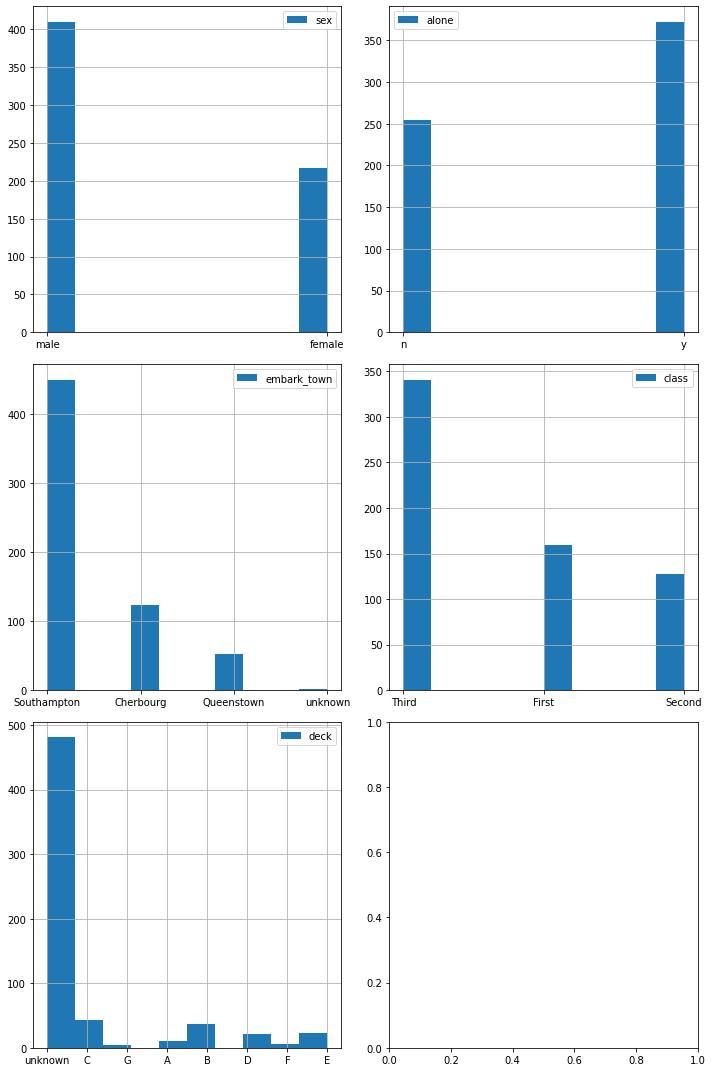

In [6]:
figure, axes = plt.subplots(3, 2, figsize=(10, 15))

train['sex'].hist(ax=axes[0,0], legend=True)
train['alone'].hist(ax=axes[0,1], legend=True)
train['embark_town'].hist(ax=axes[1,0], legend=True)
train['class'].hist(ax=axes[1,1], legend=True)
train['deck'].hist(ax=axes[2,0], legend=True)

plt.tight_layout()
plt.show()

## Create feature columns

In [7]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [8]:
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = train[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name))

In [9]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

## The Training Process

**Input function**

In [10]:
def make_input_fn(data, label, num_epochs=10, shuffle=True, batch_size=32):
  '''
  data:   input data (pandas dataframe)
  label:  label of the data (pandas dataframe)
  rest of the parameters are pretty much self-explanatory
  '''
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data), label))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

In [11]:
train_input_fn = make_input_fn(train, y_train, num_epochs=20, batch_size=64)
eval_input_fn = make_input_fn(eval, y_eval, num_epochs=1, shuffle=False)

**Creating the model**

In [12]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdkkv_j4u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


**Training the model**

In [13]:
linear_est.train(train_input_fn)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdkkv_j4u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 145.736
INFO:tensorflow:loss = 0.43240398, step = 100 (0.688 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpdkkv_j4u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:Loss for final step: 0.58397734.


## Evaluation and Prediction

**Evaluating the model**

In [14]:
result = linear_est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-06-29T17:09:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdkkv_j4u/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.82987s
INFO:tensorflow:Finished evaluation at 2022-06-29-17:09:35
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.7613636, accuracy_baseline = 0.625, auc = 0.83152735, auc_precision_recall = 0.7823028, average_loss = 0.50668687, global_step = 200, label/mean = 0.375, loss = 0.49757302, precision = 0.725, prediction/mean = 0.29488206, recall = 0.5858586
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmpdkkv_j4u/model.ckpt-200


In [15]:
result

{'accuracy': 0.7613636,
 'accuracy_baseline': 0.625,
 'auc': 0.83152735,
 'auc_precision_recall': 0.7823028,
 'average_loss': 0.50668687,
 'global_step': 200,
 'label/mean': 0.375,
 'loss': 0.49757302,
 'precision': 0.725,
 'prediction/mean': 0.29488206,
 'recall': 0.5858586}

**Make predictions**

In [16]:
predictions = list(linear_est.predict(eval_input_fn))

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdkkv_j4u/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [17]:
predictions[0]

{'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object),
 'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'logistic': array([0.05205983], dtype=float32),
 'logits': array([-2.9018977], dtype=float32),
 'probabilities': array([0.9479402 , 0.05205984], dtype=float32)}

In [18]:
print(eval.iloc[15])
print(y_eval.iloc[15])
print(predictions[15]['probabilities']) # the second item in the output list denotes the probability that the person survived

sex                        female
age                          16.0
n_siblings_spouses              5
parch                           2
fare                         46.9
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 15, dtype: object
0
[0.643774   0.35622603]


# Classification

## Data

In [19]:
COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Verginica']

In [20]:
x_train = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv',
                      names=COLUMN_NAMES, header=0
                      )
x_test = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv',
                     names=COLUMN_NAMES, header=0
                     )
y_train = x_train.pop('Species')
y_test = x_test.pop('Species')

In [21]:
x_train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [22]:
print(x_train.describe())
print(x_train.info())

       SepalLength  SepalWidth  PetalLength  PetalWidth
count   120.000000  120.000000   120.000000  120.000000
mean      5.845000    3.065000     3.739167    1.196667
std       0.868578    0.427156     1.822100    0.782039
min       4.400000    2.000000     1.000000    0.100000
25%       5.075000    2.800000     1.500000    0.300000
50%       5.800000    3.000000     4.400000    1.300000
75%       6.425000    3.300000     5.100000    1.800000
max       7.900000    4.400000     6.900000    2.500000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SepalLength  120 non-null    float64
 1   SepalWidth   120 non-null    float64
 2   PetalLength  120 non-null    float64
 3   PetalWidth   120 non-null    float64
dtypes: float64(4)
memory usage: 3.9 KB
None


[]

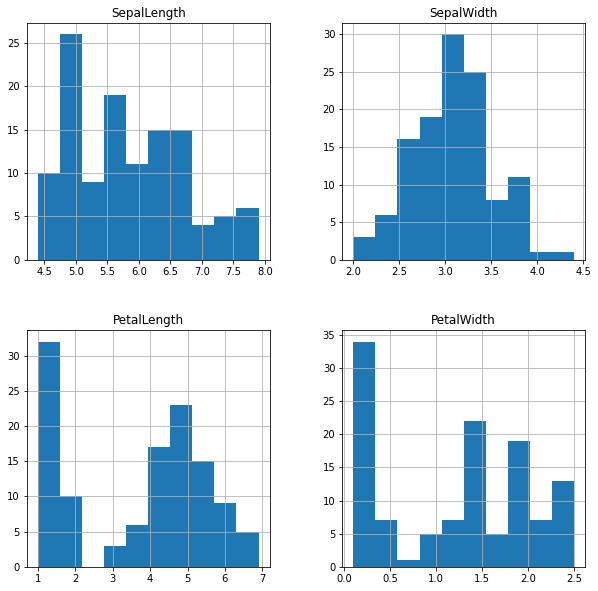

In [23]:
x_train.hist(figsize=(10,10))
plt.plot()

## Model

**Input function**

In [24]:
def input_fn(features, labels, shuffle=True, batch_size=64):
  dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
  if shuffle:
    dataset = dataset.shuffle(1000).repeat()
  return dataset.batch(batch_size)

**Feature Columns**

In [25]:
feature_columns = []
for feature_column in x_train.keys():
  feature_columns.append(tf.feature_column.numeric_column(key=feature_column))

feature_columns

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

**Building the model**

In [26]:
classifier = tf.estimator.DNNClassifier(feature_columns = feature_columns,
                                        hidden_units = [16,16],
                                        n_classes = 3
                                        )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpl0tiu_f7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


**Training the  model**

In [27]:
classifier.train(input_fn=lambda: input_fn(x_train, y_train),
                 steps=50
                 )

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpl0tiu_f7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 4.07567, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50...
INFO:tensorflow:Saving checkpoints for 50 into /tmp/tmpl0tiu_f7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50...
INFO:tensorflow:Loss for final step: 2.987464.


## Evaluation and Prediction

In [28]:
classifier.evaluate(input_fn=lambda: input_fn(x_test, y_test, shuffle=False))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-06-29T17:09:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpl0tiu_f7/model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.54907s
INFO:tensorflow:Finished evaluation at 2022-06-29-17:09:47
INFO:tensorflow:Saving dict for global step 50: accuracy = 0.26666668, average_loss = 2.289574, global_step = 50, loss = 2.289574
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 50: /tmp/tmpl0tiu_f7/model.ckpt-50


{'accuracy': 0.26666668,
 'average_loss': 2.289574,
 'global_step': 50,
 'loss': 2.289574}

In [29]:
def test_input_fn(features, batch_size=64):
  return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [30]:
predictions = classifier.predict(input_fn=lambda: test_input_fn(x_test))

for prediction in predictions:
  print(SPECIES[prediction['class_ids'][0]])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpl0tiu_f7/model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa
Setosa


# Hidden Markov Model

In [31]:
import tensorflow_probability as tfp

## Weather Model

In [32]:
tfd = tfp.distributions

In [33]:
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])
observation_distribution = tfd.Normal(loc=[0., 15.],
                                      scale=[5., 10.])

In [34]:
model = tfd.HiddenMarkovModel(
    initial_distribution = initial_distribution,
    transition_distribution = transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7
)

In [35]:
mean = model.mean()

In [36]:
with tf.compat.v1.Session() as session:
  print(mean.numpy())

[2.9999998 5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]
